# Let's implement churn base on the previous discoverys

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sellers = pd.read_csv('OLIST-DATA\olist_sellers_dataset.csv')
orders = pd.read_csv('OLIST-DATA/olist_orders_dataset.csv')
geolocation_replace = pd.read_csv('geolocation_mean_replace_geolocation_dataset.csv')
order_items = pd.read_csv('OLIST-DATA/olist_order_items_dataset.csv')

In [3]:
geo = geolocation_replace.rename(columns={'geolocation_zip_code_prefix': 'seller_zip_code_prefix'})

merged = (
    sellers
    .merge(order_items, on='seller_id', how='left')
    .merge(orders, on='order_id', how='left')
    .merge(geo, on='seller_zip_code_prefix', how='left')
)

merged

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_lat_mean,geolocation_lng_mean,geolocation_lat_std,geolocation_lng_std
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,...,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01 00:00:00,-22.893848,-47.061337,0.003859,0.004621
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,...,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30 00:00:00,-22.893848,-47.061337,0.003859,0.004621
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,...,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20 00:00:00,-22.893848,-47.061337,0.003859,0.004621
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,...,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04 00:00:00,-22.383437,-46.947927,0.006931,0.006135
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,...,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03 00:00:00,-22.383437,-46.947927,0.006931,0.006135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.00,16.05,...,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28 00:00:00,-31.751072,-52.323202,0.006777,0.006501
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.00,10.96,...,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10 00:00:00,-31.751072,-52.323202,0.006777,0.006501
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.00,16.05,...,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03 00:00:00,-31.751072,-52.323202,0.006777,0.006501
112648,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,d1edb80f6670902ebbb11765b96873da,1,e891d4a9622cae3b9fc2ec558bda155b,2017-06-26 17:30:16,27.00,12.48,...,canceled,2017-06-16 17:21:21,2017-06-16 17:30:16,NaN,NaN,2017-07-10 00:00:00,-31.751072,-52.323202,0.006777,0.006501


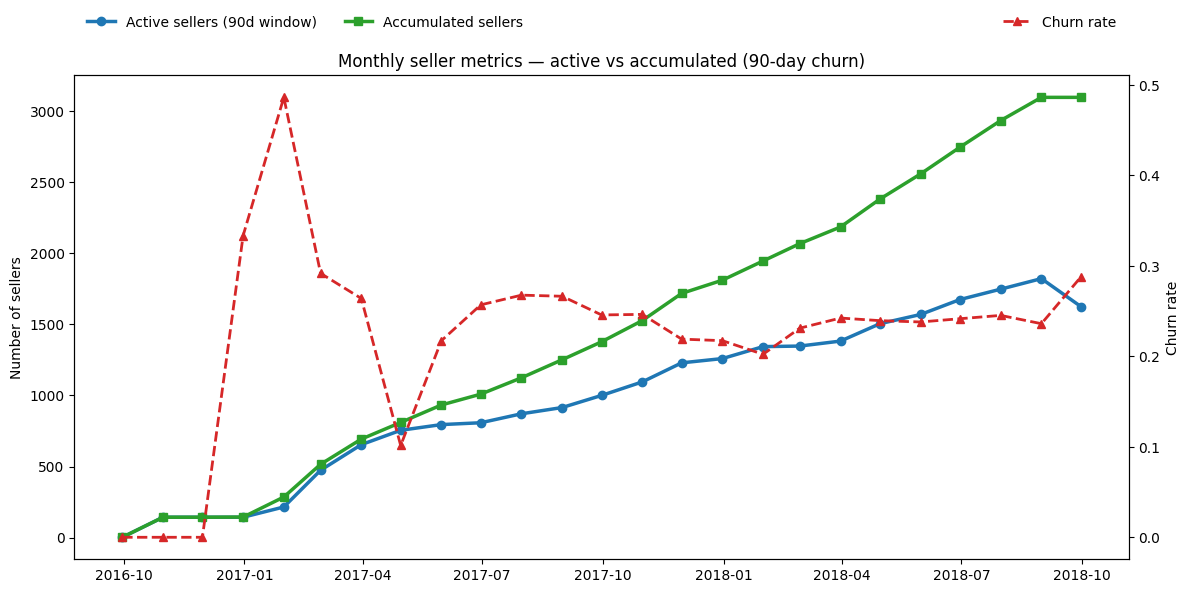

In [16]:
DF = merged.copy()

TIME_COL = 'order_purchase_timestamp'
SELLER_COL = 'seller_id'
CHURN_DAYS = 90

DF[TIME_COL] = pd.to_datetime(DF[TIME_COL], errors='coerce')
DF = DF.dropna(subset=[TIME_COL, SELLER_COL])

orders = DF[[SELLER_COL, TIME_COL]].sort_values(TIME_COL)
first_order = orders.groupby(SELLER_COL)[TIME_COL].min()

start = orders[TIME_COL].min().normalize()
end = orders[TIME_COL].max().normalize()

month_ends = pd.date_range(
    start=start,
    end=end + pd.offsets.MonthEnd(0),
    freq='ME'
)

rows = []
for t in month_ends:
    recent_from = t - pd.Timedelta(days=CHURN_DAYS)
    prior_from = t - pd.Timedelta(days=2 * CHURN_DAYS)

    recent_sellers = set(
        orders.loc[
            (orders[TIME_COL] > recent_from) & (orders[TIME_COL] <= t),
            SELLER_COL
        ].unique()
    )

    prior_sellers = set(
        orders.loc[
            (orders[TIME_COL] > prior_from) & (orders[TIME_COL] <= recent_from),
            SELLER_COL
        ].unique()
    )

    churners = prior_sellers - recent_sellers
    accumulated = int((first_order <= t).sum())

    rows.append({
        'month_end': t,
        'active_count': len(recent_sellers),
        'accumulated_sellers': accumulated,
        'churn_rate': len(churners) / len(prior_sellers) if prior_sellers else np.nan
    })

ts = (
    pd.DataFrame(rows)
    .set_index('month_end')
    .sort_index()
)

ts['churn_rate'] = ts['churn_rate'].fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    ts.index,
    ts['active_count'],
    color='tab:blue',
    linewidth=2.5,
    marker='o',
    linestyle='-',
    label='Active sellers (90d window)'
)

ax.plot(
    ts.index,
    ts['accumulated_sellers'],
    color='tab:green',
    linewidth=2.5,
    marker='s',
    linestyle='-',
    label='Accumulated sellers'
)

ax.set_ylabel('Number of sellers')

# move primary legend outside
ax.legend(
    loc='upper left',
    bbox_to_anchor=(0, 1.15),
    frameon=False,
    ncol=2
)

ax2 = ax.twinx()
ax2.plot(
    ts.index,
    ts['churn_rate'],
    color='tab:red',
    linewidth=2,
    marker='^',
    linestyle='--',
    label='Churn rate'
)

ax2.set_ylabel('Churn rate')

# move secondary legend outside
ax2.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1.15),
    frameon=False
)

plt.title('Monthly seller metrics — active vs accumulated (90-day churn)')
plt.tight_layout()
plt.show()

# คร่าว ๆ เกี่ยวกับ churn rate